Let's use all the data we expected to use (three months worth) to make predictions on the tip amount.

The data will be processed in the same way it was done on the data cleaning analysis, and then some other processing will be carried to generate potentially interesting features.

The overall process for each file will be like this:

1. Load data csv file
2. Flush entries with bad data
3. Enrich data with extra information and transform part of the data into other fields that can be better exploited by machine learning techniques
4. Save this data

Then we will put all this data together, and try some feature engineering process, and then try to make predictions. It is possible that some changes shall be made on the go as we see partial results. This is usually an iterative process.

In [2]:
import pandas as pd
import numpy as np
import fiona

import matplotlib.pyplot as plt
%matplotlib inline

Let's recall the data format from the data exploration phase:

| variable | type | comments |
| :--- | --- | ---: |
| **VendorID** | categorical | Provider of the data, note 1 |
| **tpep_pickup_datetime** 	| timestamp string | Pick Up Time in NYC local time |
| **tpep_dropoff_datetime** | timestamp string | Drop Off Time in NYC local time |
| **passenger_count** | integer | Data entered manually (by driver) |
| **trip_distance** | float | Distance in miles as per taximeter |
| **RatecodeID** | categorical | Rate code, note 1 |
| **store_and_fwd_flag**  | categorical | data storage mode |
| **PULocationID** | categorical-spatial | note 1, note 2 |
| **DOLocationID** | categorical-spatial | note 1, note 2 |
| **payment_type**  | categorical | Payment method, and null trip indicator "6", note 1 |
| **fare_amount** | float | The base charge from the taximeter |
| **extra** | float | Extra charges |
| **mta_tax** | float | Tax charges |
| **tip_amount** | float | Automatic card tip, cash tips not included |
| **tolls_amount** | float | Tolls charges |
| **improvement_surcharge** | float | Levied in 2015 |
| **total_amount** | float | Does not include cash tips |

Some basic enrichments we can perform are:

* Generate timing info which takes into account cycles:
 - Time of the day
 - Day of the week
 - Month of the year
We can choose to handle this data either as categorical data or we can choose some cycle representation which may map distances properly, such as sin(data/cycle_lenght) and cos(data/cycle_length)
* Use the areas info to include borough
* Use shapes info to include approximate latitude/longitude or equivalents
* Use calendar data to mark events that could affect our Y, such as festivities (although this task will not be used as only one such occasion has been found on the calendar, Thanksgiving)

In [4]:
zone_id=[]
borough=[]
latitude=[]
longitude=[]

with fiona.open('inputdata/shapes/taxi_zones.shp') as source:
  for shape in source:
    points=np.array(shape['geometry']['coordinates'][0])
    if len(points.shape)==3: # complex shape
        points.resize([points.shape[1], points.shape[2]])
    center=np.mean(points, axis=0) # Not rigorous, shapes can be irregular
    latitude.append(center[0])
    longitude.append(center[1])
    zone_id.append(str(shape['properties']['LocationID']))
    borough.append(shape['properties']['borough'])
geoinfo=pd.DataFrame({'LocationID': zone_id, 'Latitude': latitude, 'Longitude': longitude, 'borough': borough})

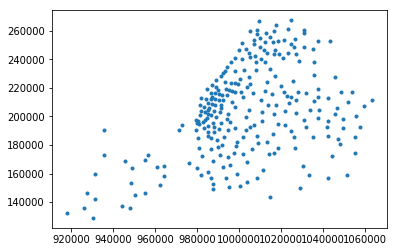

In [89]:
plt.scatter(latitude, longitude, marker='.')
plt.show()

In [9]:
input_files=['inputdata/yellow_tripdata_2017-03.csv',
             'inputdata/yellow_tripdata_2017-06.csv',
             'inputdata/yellow_tripdata_2017-11.csv']
output_files=['outputdata/3.csv',
              'outputdata/6.csv',
              'outputdata/11.csv', ]
for inputfile, outputfile in zip(input_files, output_files):
    print("Loading data...")
    data = pd.read_csv(inputfile, 
                       dtype={'PULocationID':str, 'DOLocationID':str, 'RatecodeID':str,  'payment_type':str,
                              'VendorID':str})
    print("Converting datetime...")
    data['tpep_pickup_datetime']=pd.to_datetime(data['tpep_pickup_datetime'],
                                                format='%Y-%m-%d %H:%M:%S',
                                                errors='coerce')
    data['tpep_dropoff_datetime']=pd.to_datetime(data['tpep_dropoff_datetime'],
                                                 format='%Y-%m-%d %H:%M:%S',
                                                 errors='coerce')

    print("Cleaning...")
    diff_date=(data['tpep_dropoff_datetime']-data['tpep_pickup_datetime']).astype('timedelta64[s]')
    bad_dates=diff_date.index[diff_date < 0].tolist()
    bad_distance=data.index[data['trip_distance'] <= 0].tolist()
    bad_RatecodeID=data.index[~data['RatecodeID'].isin([str(x) for x in range(1,7)])].tolist()
    bad_charges=data.index[(data['fare_amount'] < 0) | (data['extra'] < 0) |
                           (data['mta_tax'] < 0) | (data['tip_amount'] < 0) |
                           (data['tolls_amount'] < 0) | (data['improvement_surcharge'] < 0) |
                           (data['total_amount'] < 0)]
    bad_entries=set(bad_dates) | set(bad_distance) | set(bad_RatecodeID) | set(bad_charges)
    data=data.drop(data.index[list(bad_entries)])
    
    print("Imputing...")
    mean_passenger=np.mean(data['passenger_count'])
    data[data['passenger_count']<1] = mean_passenger
    
    print("Adding conversions...")
    # Nasty behaviour from pandas, need to convert again??
    data['tpep_pickup_datetime']=pd.to_datetime(data['tpep_pickup_datetime'],
                                                format='%Y-%m-%d %H:%M:%S',
                                                errors='coerce')
    data['tpep_dropoff_datetime']=pd.to_datetime(data['tpep_dropoff_datetime'],
                                                 format='%Y-%m-%d %H:%M:%S',
                                                 errors='coerce')
    
    # hour/minute
    data['pickup_time_sin'] = np.sin(
        (data['tpep_pickup_datetime'].dt.hour*60+data['tpep_pickup_datetime'].dt.minute)/(24*60))
    data['pickup_time_cos'] = np.cos(
        (data['tpep_pickup_datetime'].dt.hour*60+data['tpep_pickup_datetime'].dt.minute)/(24*60))
    data['dropoff_time_sin'] = np.sin(
        (data['tpep_dropoff_datetime'].dt.hour*60+data['tpep_dropoff_datetime'].dt.minute)/(24*60))
    data['dropoff_time_cos'] = np.cos(
        (data['tpep_dropoff_datetime'].dt.hour*60+data['tpep_dropoff_datetime'].dt.minute)/(24*60))

    # day and month have less variation, so let's take only pickup instances
    data['pickup_day_sin'] = np.sin(data['tpep_pickup_datetime'].dt.dayofweek/7)
    data['pickup_day_cos'] = np.cos(data['tpep_pickup_datetime'].dt.dayofweek/7)
    data['pickup_month_sin'] = np.sin(data['tpep_pickup_datetime'].dt.month/12)
    data['pickup_month_cos'] = np.cos(data['tpep_pickup_datetime'].dt.month/12)

    print("Adding area data...")
    # left join, some areas codes haven't got any shape
    data=data.merge(geoinfo, how='left', left_on='PULocationID', right_on='LocationID')
    data=data.merge(geoinfo, how='left', left_on='DOLocationID', right_on='LocationID', suffixes=('_PU', '_DO'))
    
    # Unneeded
    data.drop(['LocationID_PU', 'LocationID_DO'])
    
    print("Saving...")
    # Smaller files, enough precision
    data.to_csv(outputfile, float_format='%.3f')

Loading data...
Converting datetime...
Cleaning...
Imputing...
Adding conversions...
Adding area data...
Saving...
Loading data...
Converting datetime...
Cleaning...
Imputing...
Adding conversions...
Adding area data...
Saving...
Loading data...
Converting datetime...
Cleaning...
Imputing...
Adding conversions...
Adding area data...
Saving...
